In [1]:
%run tools.ipynb

# Model training

In [2]:
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from torch.utils.data import DataLoader
from pymatgen import Structure

from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR, ClipNorm
from xenonpy.model.training.extension import Validator, TensorConverter, Persist
from xenonpy.model.training.dataset import ArrayDataset, CrystalGraphDataset
from xenonpy.model.utils import regression_metrics
from xenonpy.model import CrystalGraphConvNet

from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions, CrystalGraphFeaturizer

## sample data

In [3]:
data = preset.mp_samples
data.head(5)

band_gap                       composition    density  \
mp-1008807    0.0000  {'Rb': 1.0, 'Cu': 1.0, 'O': 1.0}   4.784634   
mp-1009640    0.0000             {'Pr': 1.0, 'N': 1.0}   8.145777   
mp-1016825    0.7745  {'Hf': 1.0, 'Mg': 1.0, 'O': 3.0}   6.165888   
mp-1017582    0.0000  {'La': 1.0, 'Pt': 3.0, 'C': 1.0}  14.284261   
mp-1021511    1.5186             {'Cd': 1.0, 'S': 1.0}   2.582691   

            e_above_hull    efermi     elements  final_energy_per_atom  \
mp-1008807      0.996372  1.100617  [Rb, Cu, O]              -3.302762   
mp-1009640      0.759393  5.213442      [Pr, N]              -7.082624   
mp-1016825      0.589550  2.424570  [Hf, Mg, O]              -7.911723   
mp-1017582      0.523635  8.160496  [La, Pt, C]              -6.684482   
mp-1021511      0.252860 -2.121180      [Cd, S]              -2.909105   

            formation_energy_per_atom pretty_formula  \
mp-1008807                  -0.186408          RbCuO   
mp-1009640                  -0.714336            PrN   
mp-1016825                  -3.060060         HfMgO3   
mp-1017582                  -0.215712         LaPt3C   
mp-1021511                  -0.719529            CdS   

                                                    structure     volume  
mp-1008807  [[-3.05935361 -3.05935361 -3.05935361] Rb, [0....  57.268924  
mp-1009640  [[0. 0. 0.] Pr, [1.57925232 1.57925232 1.58276...  31.579717  
mp-1016825  [[2.03622802 2.03622802 2.03622802] Hf, [0. 0....  67.541269  
mp-1017582  [[0. 0. 0.] La, [0.         2.20339716 2.20339...  85.579224  
mp-1021511  [[2.12807605 1.22864286 2.67990375] Cd, [-2.46...  92.890725

## compositional descriptor

In [4]:
prop = data[data.volume <= 2500]['volume'].to_frame()
desc = Compositions(featurizers='classic').transform(data.loc[prop.index]['composition'])

desc.head(5)
prop.head(5)

ave:atomic_number  ave:atomic_radius  ave:atomic_radius_rahm  \
mp-1008807          24.666667         174.067140              209.333333   
mp-1009640          33.000000         137.000000              232.500000   
mp-1016825          21.600000         153.120852              203.400000   
mp-1017582          59.400000         139.000000              232.800000   
mp-1021511          32.000000         140.500000              226.000000   

            ave:atomic_volume  ave:atomic_weight  ave:boiling_point  \
mp-1008807          25.666667          55.004267        1297.063333   
mp-1009640          19.050000          77.457330        1931.200000   
mp-1016825          13.920000          50.158400        1420.714000   
mp-1017582          11.020000         147.233694        4226.000000   
mp-1021511          14.300000          72.237000         877.912000   

            ave:bulk_modulus  ave:c6_gb  ave:covalent_radius_cordero  \
mp-1008807         72.868680    1646.90                   139.333333   
mp-1009640         43.182441    1892.85                   137.000000   
mp-1016825         76.663625     343.82                   102.800000   
mp-1017582        150.200000    1037.58                   137.600000   
mp-1021511         24.850000     272.50                   124.500000   

            ave:covalent_radius_pyykko  ...  min:num_s_valence  min:period  \
mp-1008807                  128.333333  ...                1.0         2.0   
mp-1009640                  123.500000  ...                2.0         2.0   
mp-1016825                   96.000000  ...                2.0         2.0   
mp-1017582                  124.800000  ...                1.0         2.0   
mp-1021511                  119.500000  ...                2.0         3.0   

            min:specific_heat  min:thermal_conductivity  min:vdw_radius  \
mp-1008807              0.360                   0.02658           152.0   
mp-1009640              0.192                   0.02583           155.0   
mp-1016825              0.146                   0.02658           152.0   
mp-1017582              0.133                  13.00000           170.0   
mp-1021511              0.232                   0.20500           180.0   

            min:vdw_radius_alvarez  min:vdw_radius_mm3  min:vdw_radius_uff  \
mp-1008807                   150.0               182.0               349.5   
mp-1009640                   166.0               193.0               360.6   
mp-1016825                   150.0               182.0               302.1   
mp-1017582                   177.0               204.0               275.4   
mp-1021511                   189.0               215.0               284.8   

            min:sound_velocity  min:Polarizability  
mp-1008807               317.5               0.802  
mp-1009640               333.6               1.100  
mp-1016825               317.5               0.802  
mp-1017582              2475.0               1.670  
mp-1021511              2310.0               2.900  

[5 rows x 290 columns]

volume
mp-1008807  57.268924
mp-1009640  31.579717
mp-1016825  67.541269
mp-1017582  85.579224
mp-1021511  92.890725

In [5]:
sp = Splitter(prop.shape[0])
x_train, x_val, y_train, y_val = sp.split(desc, prop)

In [6]:
x_train.shape
y_train.shape
x_val.shape
y_val.shape

(738, 290)

(738, 1)

(185, 290)

(185, 1)

In [14]:
model = torch.nn.Sequential(
    torch.nn.Linear(290, 200),
    torch.nn.BatchNorm1d(200),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(200, 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(100, 1),
)
model

Sequential(
  (0): Linear(in_features=290, out_features=200, bias=True)
  (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.1)
  (8): Linear(in_features=100, out_features=1, bias=True)
)

In [16]:
trainer = Trainer(
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss(),
    clip_grad=ClipNorm(max_norm=0.5),
    lr_scheduler=ExponentialLR(gamma=0.99),
)

In [17]:
trainer.extend(
    TensorConverter(),
    Validator(metrics_func=regression_metrics, early_stopping=5, trace_order=5, mae=0.0, pearsonr=1.0),
)

In [18]:
train_dataset = DataLoader(ArrayDataset(x_train, y_train), shuffle=True, batch_size=1000)
val_dataset = DataLoader(ArrayDataset(x_val, y_val), batch_size=1000)

In [19]:
persist = Persist('test_model', increment=True, sync_training_step=True)
trainer.extend(persist)
trainer.reset(to=model)

In [20]:
trainer.fit(training_dataset=train_dataset, validation_dataset=val_dataset, epochs=10)

Training: 100%|██████████| 10/10 [00:00<00:00, 25.04it/s]


In [21]:
trainer['persist'].model_structure

Sequential(
  (0): Linear(in_features=290, out_features=200, bias=True)
  (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.1)
  (8): Linear(in_features=100, out_features=1, bias=True)
)


'Sequential(\n  (0): Linear(in_features=290, out_features=200, bias=True)\n  (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (2): ReLU()\n  (3): Dropout(p=0.1)\n  (4): Linear(in_features=200, out_features=100, bias=True)\n  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (6): ReLU()\n  (7): Dropout(p=0.1)\n  (8): Linear(in_features=100, out_features=1, bias=True)\n)'

In [16]:
trainer.training_info.head(5)

total_iters  i_epoch  i_batch  train_mse_loss     val_mae       val_mse  \
0            1        1        1    412426.46875  440.195770  386787.81250   
1            2        2        1    412127.28125  439.935394  386543.06250   
2            3        3        1    411895.40625  439.896790  386497.71875   
3            4        4        1    411632.93750  439.770111  386365.50000   
4            5        5        1    411355.40625  439.558838  386139.68750   

     val_rmse    val_r2  val_pearsonr  val_spearmanr  val_p_value   val_max_ae  
0  621.922668 -1.003871      0.043379      -0.036405     0.557682  2450.045898  
1  621.725891 -1.002603      0.055332       0.035912     0.454417  2449.945557  
2  621.689392 -1.002369      0.091608       0.032120     0.214915  2449.918945  
3  621.583069 -1.001683      0.131899       0.059636     0.073505  2449.862305  
4  621.401367 -1.000514      0.162956       0.123181     0.026674  2449.797119

In [34]:
trainer.get_checkpoint()

['mae:1',
 'pearsonr:1',
 'mae:2',
 'pearsonr:2',
 'mae:3',
 'pearsonr:3',
 'mae:4',
 'pearsonr:4',
 'mae:5',
 'pearsonr:5']

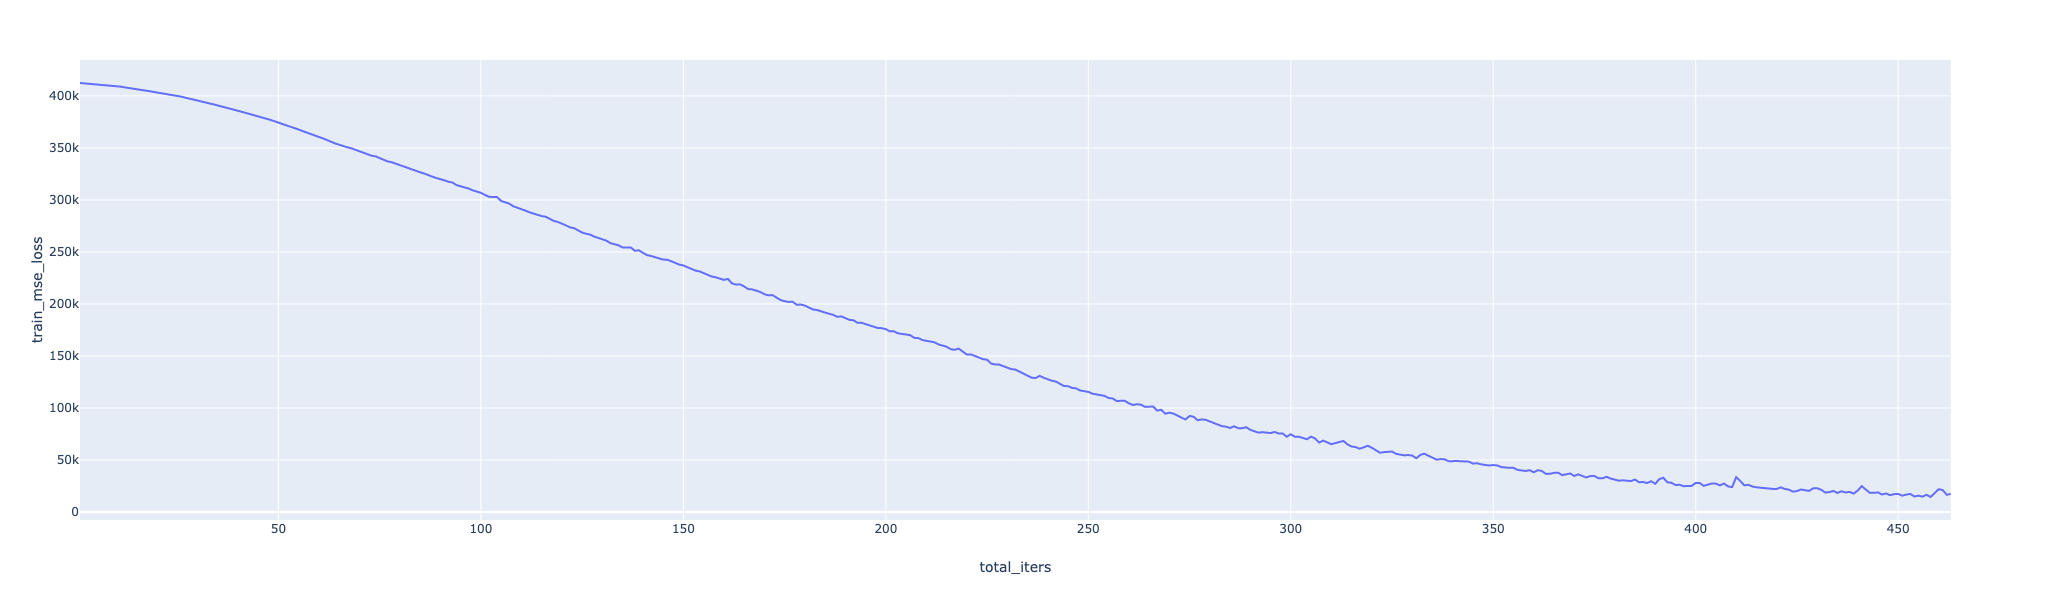

In [18]:
fig = px.line(trainer.training_info, x='total_iters', y='train_mse_loss')
fig.show()


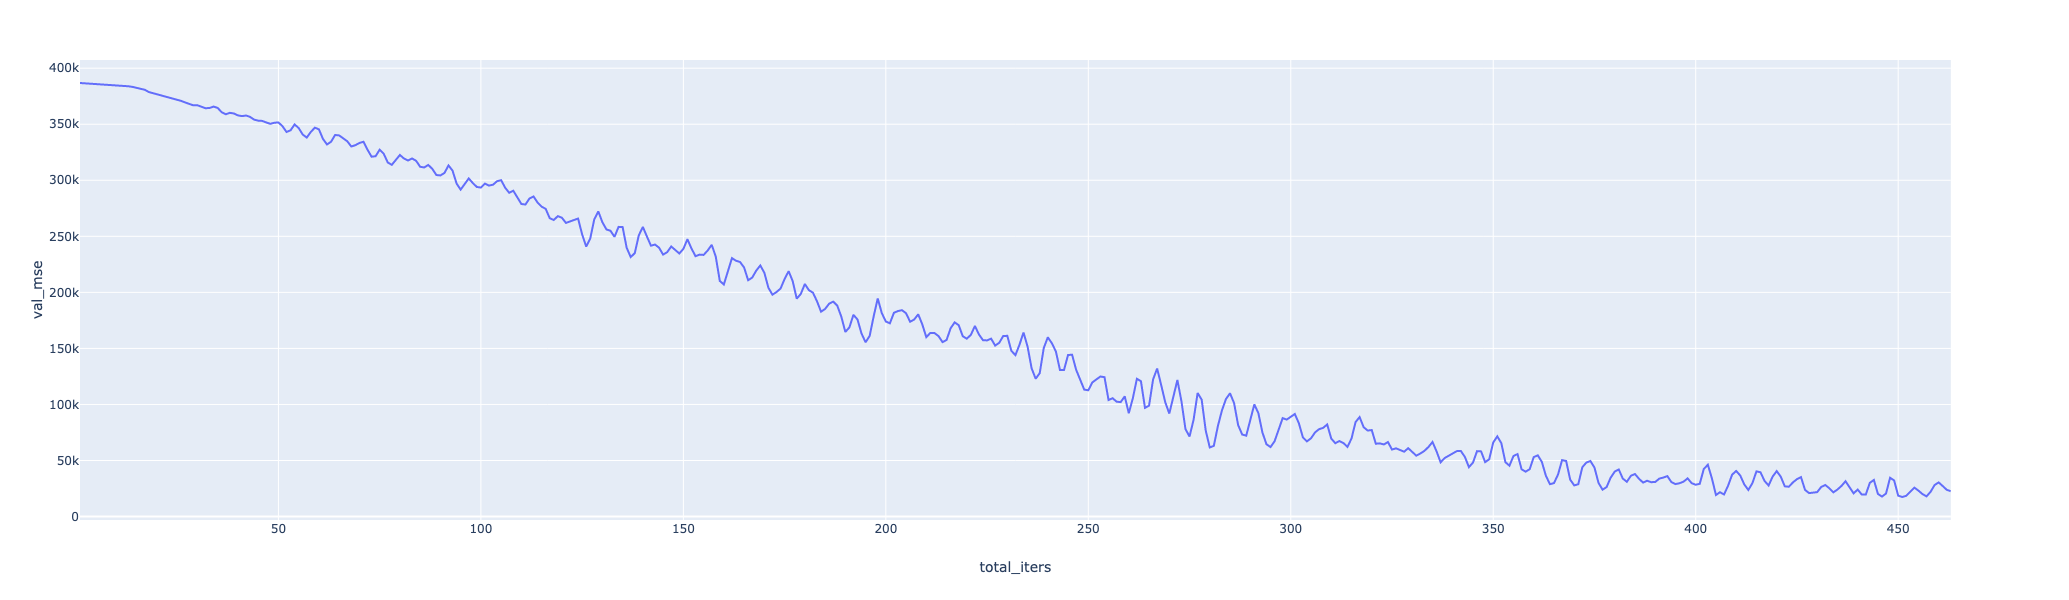

In [19]:
fig = px.line(trainer.training_info, x='total_iters', y='val_mse')
fig.show()


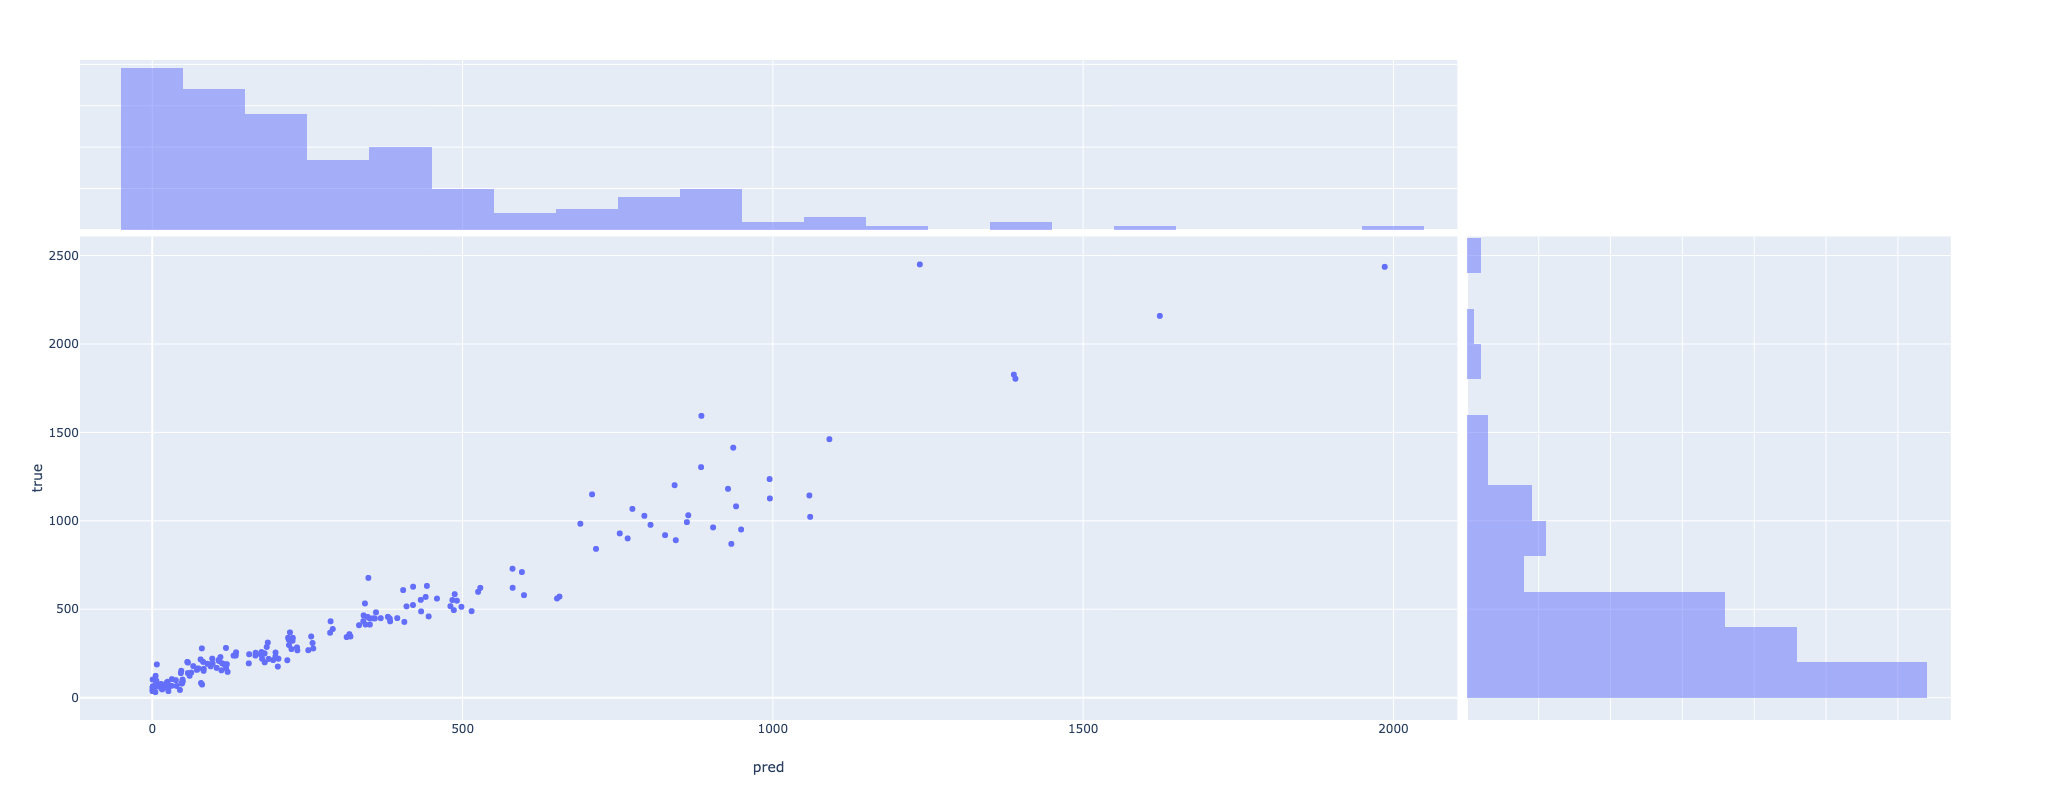

In [24]:
y_pred, y_true = trainer.predict(dataset=val_dataset, checkpoint='pearsonr:1')
fig = px.scatter(pd.DataFrame({'pred': y_pred.flatten(), 'true': y_true.flatten()}), x='pred', y='true', width=800, height=800, marginal_x='histogram', marginal_y='histogram')
fig.show()

## crystal graph cnn

In [4]:
desc = CrystalGraphFeaturizer().transform(data['structure'])
prop = data['volume'].to_frame()

desc.head(5)
prop.head(5)

atom_feature  \
mp-1008807  [[tensor(0.), tensor(1.), tensor(0.), tensor(0...   
mp-1009640  [[tensor(1.), tensor(0.), tensor(0.), tensor(0...   
mp-1016825  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...   
mp-1017582  [[tensor(1.), tensor(0.), tensor(0.), tensor(0...   
mp-1021511  [[tensor(0.), tensor(0.), tensor(0.), tensor(0...   

                                             neighbor_feature  \
mp-1008807  [[[tensor(0.), tensor(0.), tensor(0.), tensor(...   
mp-1009640  [[[tensor(0.), tensor(0.), tensor(0.), tensor(...   
mp-1016825  [[[tensor(1.4013e-45), tensor(2.4653e-37), ten...   
mp-1017582  [[[tensor(0.), tensor(0.), tensor(0.), tensor(...   
mp-1021511  [[[tensor(0.), tensor(0.), tensor(0.), tensor(...   

                                                 neighbor_idx  
mp-1008807  [[tensor(2), tensor(2), tensor(2), tensor(2), ...  
mp-1009640  [[tensor(1), tensor(1), tensor(1), tensor(1), ...  
mp-1016825  [[tensor(2), tensor(3), tensor(4), tensor(2), ...  
mp-1017582  [[tensor(1), tensor(2), tensor(3), tensor(1), ...  
mp-1021511  [[tensor(1), tensor(1), tensor(1), tensor(0), ...

volume
mp-1008807  57.268924
mp-1009640  31.579717
mp-1016825  67.541269
mp-1017582  85.579224
mp-1021511  92.890725

In [5]:
sp = Splitter(prop.shape[0])
x_train, x_test, y_train, y_test = sp.split(desc, prop)

In [6]:
x_train.shape
y_train.shape
x_test.shape
y_test.shape

(743, 3)

(743, 1)

(186, 3)

(186, 1)

In [7]:
train_dataloader = DataLoader(CrystalGraphDataset(x_train, y_train), shuffle=True,
                              batch_size=20, collate_fn=CrystalGraphDataset.collate_fn)
val_dataloader = DataLoader(CrystalGraphDataset(x_test, y_test),
                              batch_size=20, collate_fn=CrystalGraphDataset.collate_fn)

In [8]:
cgcnn = CrystalGraphConvNet(orig_atom_fea_len=92, nbr_fea_len=41, atom_fea_len=128, h_fea_len=64, n_conv=1, n_h=1)
cgcnn

CrystalGraphConvNet(
  (embedding): Linear(in_features=92, out_features=128, bias=True)
  (convs): ModuleList(
    (0): ConvLayer(
      (fc_full): Linear(in_features=297, out_features=256, bias=True)
      (sigmoid): Sigmoid()
      (softplus1): Softplus(beta=1, threshold=20)
      (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (softplus2): Softplus(beta=1, threshold=20)
    )
  )
  (conv_to_fc): Linear(in_features=128, out_features=64, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1, threshold=20)
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
trainer = Trainer(
    model=cgcnn,
    optimizer=Adam(lr=0.0005),
    loss_func=MSELoss(),
    lr_scheduler=ExponentialLR(gamma=0.99),
    clip_grad=ClipNorm(max_norm=0.04)
)

In [10]:
trainer.extend(
    TensorConverter(),
    Validator(metrics_func=regression_metrics, early_stopping=30, pearsonr=1.0, mse=0.0, r2=0.0, mae=0.0),
)

In [11]:
trainer.fit(training_dataset=train_dataloader, validation_dataset=val_dataloader, epochs=100)

Training:  11%|█         | 11/100 [03:06<26:49, 18.09s/it]/Users/liuchang/projects/xenonpy/xenonpy/model/training/trainer.py:390: UserWarning:

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] in the last 31 iterations, finish training at iterations 11




In [12]:
trainer.step_info.head(5)

total_iters  i_epoch  i_batch     train_loss     val_mae      val_mse  \
0            1        1        1  343781.875000  500.848969  552324.3750   
1            2        1        2  800263.812500  500.569000  552043.5000   
2            3        1        3  349451.875000  500.286285  551760.0625   
3            4        1        4  150381.171875  500.001923  551475.2500   
4            5        1        5  253343.234375  499.715851  551189.0625   

     val_rmse        val_r2  val_pearsonr  val_spearmanr  val_p_value  \
0  743.185303 -1.273074e+09      0.171313      -0.058553     0.019390   
1  742.996277 -1.418644e+09      0.205430       0.000609     0.004910   
2  742.805542 -1.600670e+09      0.241836       0.106198     0.000883   
3  742.613770 -1.751977e+09      0.269444       0.214699     0.000200   
4  742.421082 -1.777963e+09      0.283157       0.305613     0.000090   

   val_max_error  
0    3324.069580  
1    3323.794434  
2    3323.517578  
3    3323.239990  
4    3322.961670

In [15]:
trainer.get_checkpoint()

['pearsonr', 'mse', 'r2', 'mae']

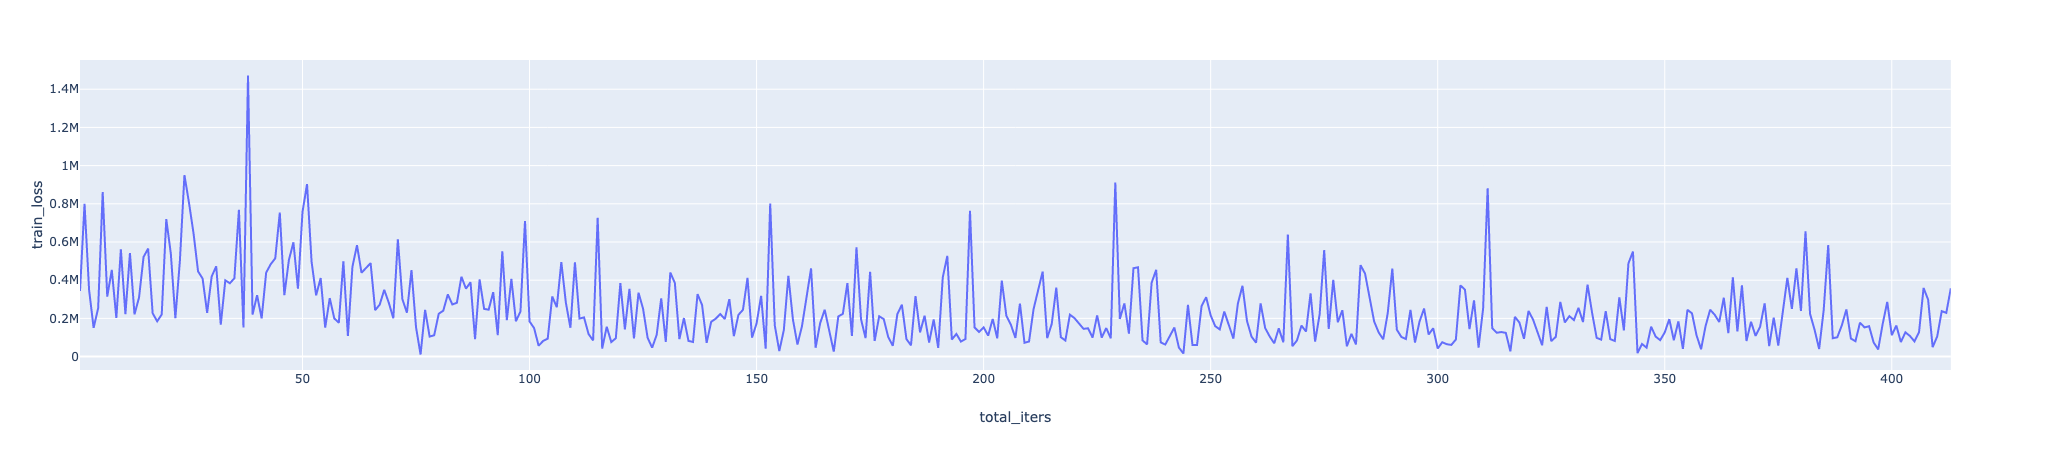

In [16]:
fig = px.line(trainer.training_info, x='total_iters', y='train_mse_loss')
fig.show()


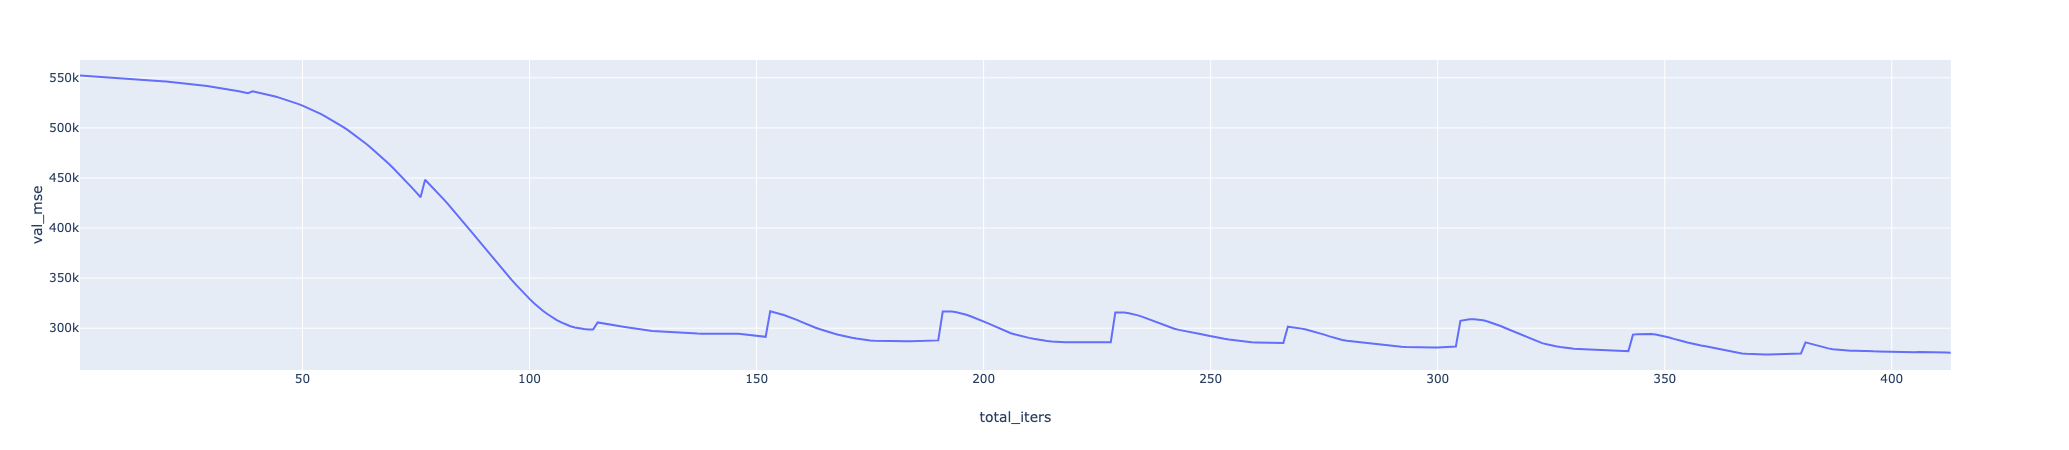

In [17]:
fig = px.line(trainer.training_info, x='total_iters', y='val_mse')
fig.show()
